In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random

from tqdm import tqdm


from resnet import ResNet18

In [2]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
device

GeForce RTX 2070 SUPER


device(type='cuda', index=0)

In [45]:
batch_size = 128
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def load_data():    
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), 
                                    transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    dataset = {'train': trainset, 'test': testset}
    data_loader = {'train': train_loader, 'test': test_loader}
    return dataset, data_loader

def load_iter(data_loader, data_type):
    bar_format = '{bar:30} {n_fmt}/{total_fmt} [{elapsed}<{remaining} {rate_fmt}] {desc}'
    
    if data_type == 'train':
        train_loader = data_loader['train']
        train_iter = tqdm(enumerate(train_loader), total=len(train_loader), unit_scale=batch_size, bar_format=bar_format)
        return train_iter
    elif data_type == 'test':
        test_loader = data_loader['test']
        test_iter = tqdm(enumerate(test_loader), total=len(test_loader), unit_scale=batch_size, bar_format=bar_format)
        return test_iter
    else:
        print('Data Error!!!')

In [4]:
def imshow(img):
    img[0] = img[0] * 0.2023 + 0.4914
    img[1] = img[1] * 0.1994 + 0.4822
    img[2] = img[2] * 0.2010 + 0.4465
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
def save_model(epoch, acc, optimizer):
    global best_acc
    if acc > best_acc:
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'optimizer': optimizer.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/model_{epoch}.pth')
        best_acc = acc
        print('Saving Model...')

def load_model(name):
    state_dict = torch.load(f'./models/{name}.pth', map_location=device)
    model = ResNet18()
    model.to(device)
    model.load_state_dict(state_dict['model'])
    optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
#     optimizer.load_state_dict(state_dict['optimizer'])
    return model, optimizer

In [6]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
#     perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

## FGSM Attack

In [7]:
def attack(model, epsilon):
    model.eval()
    test_loss = 0
    correct = 0
    success = 0
    total = 0
    test_iter = load_iter(data_loader, 'test')
    for i, (batch, label) in test_iter:
        batch, label = batch.to(device), label.to(device)
        batch.requires_grad = True
        output = model(batch)
        loss = loss_function(output, label)
        _, predicted = output.max(1)
        
        model.zero_grad()
        loss.backward()
        batch_grad = batch.grad.data
        for i, data in enumerate(batch.clone()):
            if label[i].item() == predicted[i].item():
                data_grad = batch_grad[i]
                perturbed_image = fgsm_attack(data, epsilon, data_grad)
                batch[i] = perturbed_image
                if i == 12:
                    imshow(data)
                    imshow(perturbed_image)
            else:
                batch[i] = data
        
        new_output = model(batch)
        _, new_predicted = new_output.max(1)
        
        total += label.size(0)
        correct += new_predicted.eq(label).sum().item()
        success += (~new_predicted.eq(predicted)).sum().item()

        acc = 100. * correct / total
        test_iter.set_description(f'[{acc:.2f}%({correct}/{total}) {success}]', False)
    return acc

Files already downloaded and verified
Files already downloaded and verified


                               0/10112 [00:00<? ?it/s] 

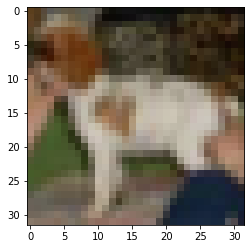

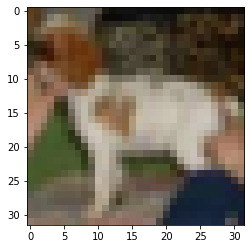

▍                              128/10112 [00:07<09:13 18.05it/s] [78.12%(100/128) 21]: 


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 8.00 GiB total capacity; 1.40 GiB already allocated; 0 bytes free; 1.45 GiB reserved in total by PyTorch)

In [10]:
# FGSM Attack
model, optimizer = load_model('baseline')
loss_function = nn.CrossEntropyLoss()
epsilon = 0.01
_, data_loader = load_data()
attack(model, epsilon)

## Data Augmentation

In [30]:
def collect_advs(model, epsilon):
    model.eval()
    test_loss = 0
    correct = 0
    success = 0
    total = 0
    adv_instances = []
    test_iter = load_iter(data_loader, 'test')
    
    for j, (batch, label) in test_iter:
        batch, label = batch.to(device), label.to(device)
        batch.requires_grad = True
        output = model(batch)
        loss = loss_function(output, label)
        _, predicted = output.max(1)
        
        model.zero_grad() #Note to my self:
                          #IF all your model parameters are in that optimizer,
                          #model.zero_grad() and optimizer.zero_grad() are the same 
        loss.backward()
        batch_grad = batch.grad.data #Derive gradient value w.r.t each data instance(in the batch)
        for i, data in enumerate(batch.clone()): 
            if label[i].item() == predicted[i].item():
                data_grad = batch_grad[i]
                perturbed_image = fgsm_attack(data, epsilon, data_grad)
                #batch[i] = perturbed_image
                _, perutb_predict = model(perturbed_image.view(1,3,32,32)).max(1)
                #print("Output shape", perutb_predict)
                #check perturbed one is also adversarial
                if perutb_predict.item() != predicted[i].item():
                    adv_instances.append(perturbed_image)
        test_iter.set_description(f'[# of Collected Adv Instances : {len(adv_instances)}]', False)
    return adv_instances

In [46]:
model, optimizer = load_model('baseline')
loss_function = nn.CrossEntropyLoss()
epsilon = 0.01
dataset, data_loader = load_data()
adv_instances = collect_advs(model, epsilon)

Files already downloaded and verified
Files already downloaded and verified


██████████████████████████████ 10112/10112 [00:34<00:00 289.85it/s] [# of Collected Adv Instances : 1945]: 


In [41]:
def slices_advs(adv_colls, shuffle_seed=None, slice_by=5): # '''slice_by씩''' 끊어서 자르기
    if not shuffle_seed:
        random.Random(shuffle_seed).shuffle(adv_colls)
        
    slices = []
    for i in range(0, len(adv_colls), slice_by):
        slices.append(adv_colls[i:i + slice_by])
        
    return slices 

slices = slices_advs(adv_instances)

In [43]:
class AdvDataSet(Dataset):
    def __init__(self, adv_instances):
        self.adv_instances = adv_instances
        
    def __len__(self):
        return len(self.adv_instances)
    
    def __getitem__(self, idx):
        return self.adv_instances[idx]

In [47]:
advset = AdvDataSet(adv_instances)
trainset = dataset['train']
ConcatDataset([advset,trainset])

In [52]:
#final packaging function
def advaug_datasets(original_dataset, adv_col_slices): #original_dataset: 원래 데이터셋, torch.tuils.data.Dataset
                                                        #adv_col_slices: lists of list of adveseiral instances(slices_advs output)
    dataset_list = []
    for i in range(len(adv_col_slices)):
        dataset = ConcatDataset([AdvDataSet(adv_col_slices[i]),trainset])
        dataset_list.append(dataset)
    return dataset_list

dataset_list = advaug_datasets(trainset, slices)

50005